In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from scipy.stats import randint as sp_randint, uniform as sp_uniform
from sklearn.preprocessing import StandardScaler


import time



In [85]:
df_train = pd.read_csv("../regression_train.csv")
df_test = pd.read_csv("../regression_test.csv")

In [86]:
continuous_features = [
    'homes_sold', 'inventory', 'median_dom',
    'off_market_in_two_weeks', 'avg_sale_to_list', 'sold_above_list',
    'median_sale_price_mom', 'median_sale_price_yoy',
    'homes_sold_mom', 'homes_sold_yoy',
    'inventory_mom', 'inventory_yoy',
    'median_dom_mom', 'median_dom_yoy'
]

# Fit scaler on training data ONLY
scaler = StandardScaler()
df_train[continuous_features] = scaler.fit_transform(df_train[continuous_features])
df_test[continuous_features] = scaler.transform(df_test[continuous_features])

In [87]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9254 entries, 0 to 9253
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   region                   9254 non-null   int64  
 1   period_begin             9254 non-null   object 
 2   homes_sold               9254 non-null   float64
 3   inventory                9254 non-null   float64
 4   median_dom               9254 non-null   float64
 5   off_market_in_two_weeks  9254 non-null   float64
 6   avg_sale_to_list         9254 non-null   float64
 7   sold_above_list          9254 non-null   float64
 8   median_sale_price_mom    9254 non-null   float64
 9   median_sale_price_yoy    9254 non-null   float64
 10  homes_sold_mom           9254 non-null   float64
 11  homes_sold_yoy           9254 non-null   float64
 12  inventory_mom            9254 non-null   float64
 13  inventory_yoy            9254 non-null   float64
 14  median_dom_mom          

In [88]:

TARGET_COL = 'log_price'
features = [
    'homes_sold', 'inventory', 'median_dom', 
    'off_market_in_two_weeks', 'avg_sale_to_list', 'sold_above_list',
    'median_sale_price_mom', 'median_sale_price_yoy',
    'homes_sold_mom', 'homes_sold_yoy',
    'inventory_mom', 'inventory_yoy',
    'median_dom_mom', 'median_dom_yoy',
    'year', 'state_NC', 'covid_era',
    'Q_1', 'Q_2', 'Q_3', 'Q_4'
]

In [89]:

X_train = df_train[features]
y_train = df_train[TARGET_COL]

X_test = df_test[features]
y_test = df_test[TARGET_COL]

print(f"Regression Target: {TARGET_COL}")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Number of Features: {len(features)}")


Regression Target: log_price
Training data shape: (9254, 21)
Testing data shape: (2511, 21)
Number of Features: 21


In [90]:

gbr_model = GradientBoostingRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3, 
    random_state=42
)

rf_model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    random_state=42, 
    n_jobs=-1
)

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Standard regression objective
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)


start_time = time.time()
gbr_model.fit(X_train, y_train)
gbr_train_time = time.time() - start_time
gbr_pred_test = gbr_model.predict(X_test)
print(f"GBR Training Time: {gbr_train_time:.2f} seconds")


start_time = time.time()
rf_model.fit(X_train, y_train)
rf_train_time = time.time() - start_time
print(f"RF Training Time: {rf_train_time:.2f} seconds")

start_time = time.time()
xgb_model.fit(X_train, y_train)
xgb_train_time = time.time() - start_time
print(f"XGB Training Time: {xgb_train_time:.2f} seconds")

GBR Training Time: 2.09 seconds
RF Training Time: 0.60 seconds
XGB Training Time: 0.19 seconds


In [91]:
def evaluate_regression_model(model, X_test, y_test):
    """Predicts, calculates R2, and calculates MAE/RMSE on the original scale."""
    
 
    y_pred_log = model.predict(X_test)

    r2 = r2_score(y_test, y_pred_log)

    y_test_price = np.exp(y_test)
    y_pred_price = np.exp(y_pred_log)

    mae_price = mean_absolute_error(y_test_price, y_pred_price)
    rmse_price = np.sqrt(mean_squared_error(y_test_price, y_pred_price))
    
    return r2, mae_price, rmse_price

# Evaluate Gradient Boosting Regressor
gbr_r2, gbr_mae, gbr_rmse = evaluate_regression_model(gbr_model, X_test, y_test)

print("\n--- Gradient Boosting Regressor Performance ---")
print(f"R2 Score (log_price): {gbr_r2:.4f}")
print(f"MAE (median_sale_price): ${gbr_mae:,.2f}")
print(f"RMSE (median_sale_price): ${gbr_rmse:,.2f}")

# Evaluate Random Forest Regressor
rf_r2, rf_mae, rf_rmse = evaluate_regression_model(rf_model, X_test, y_test)

print("\n--- Random Forest Regressor Performance ---")
print(f"R2 Score (log_price): {rf_r2:.4f}")
print(f"MAE (median_sale_price): ${rf_mae:,.2f}")
print(f"RMSE (median_sale_price): ${rf_rmse:,.2f}")

xgb_r2, xgb_mae, xgb_rmse = evaluate_regression_model(xgb_model, X_test, y_test)

print("\n--- XGBoost Regressor Performance ---")
print(f"R2 Score (log_price): {xgb_r2:.4f}")
print(f"MAE (median_sale_price): ${xgb_mae:,.2f}")
print(f"RMSE (median_sale_price): ${xgb_rmse:,.2f}")


--- Gradient Boosting Regressor Performance ---
R2 Score (log_price): -0.2220
MAE (median_sale_price): $102,929.45
RMSE (median_sale_price): $167,898.81

--- Random Forest Regressor Performance ---
R2 Score (log_price): -0.3209
MAE (median_sale_price): $105,951.40
RMSE (median_sale_price): $171,935.26

--- XGBoost Regressor Performance ---
R2 Score (log_price): -0.3143
MAE (median_sale_price): $105,912.36
RMSE (median_sale_price): $170,951.31


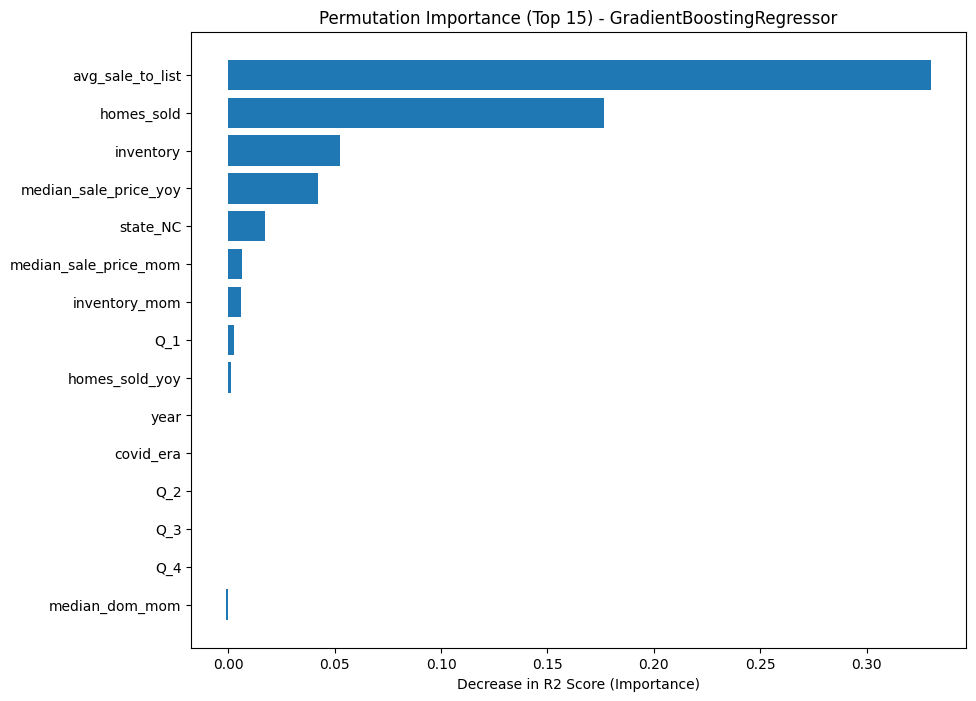

In [92]:

model_for_importance = gbr_model


results = permutation_importance(
    model_for_importance,   
    X_test,                 
    y_test,                 
    n_repeats=10,           
    random_state=42,
    n_jobs=-1
)

importances = results.importances_mean
feature_names = X_test.columns

importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)

# Plot top 15 features
top_n = 15
plt.figure(figsize=(10,8))
plt.barh(importance_df['feature'].head(top_n), importance_df['importance'].head(top_n))
plt.gca().invert_yaxis()
plt.title(f'Permutation Importance (Top {top_n}) - {model_for_importance.__class__.__name__}')
plt.xlabel('Decrease in R2 Score (Importance)')
plt.show()

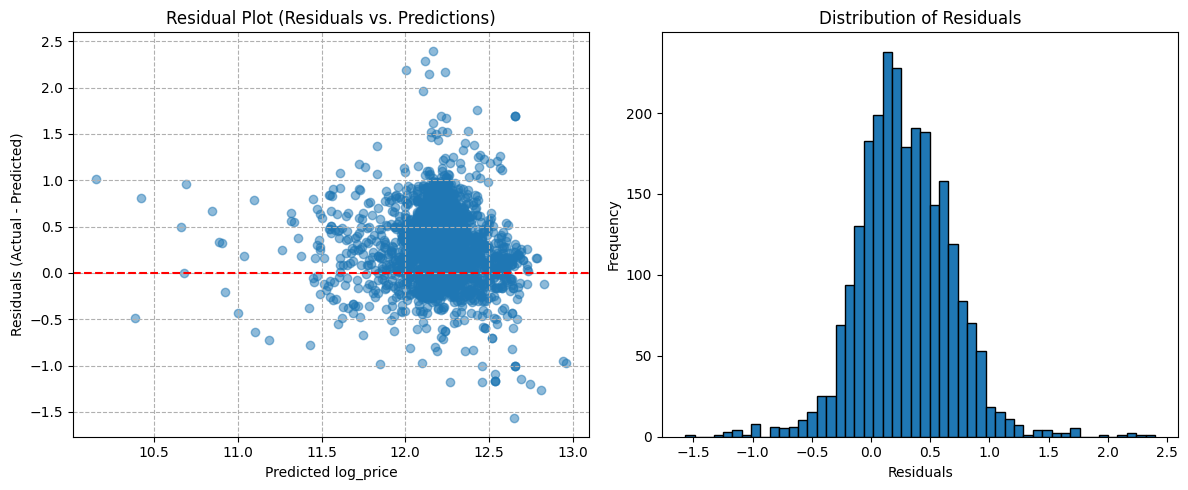

In [93]:

best_model = gbr_model 
y_pred_log = best_model.predict(X_test)
residuals = y_test - y_pred_log

plt.figure(figsize=(12, 5))

# Scatter Plot of Residuals vs. Predicted Values
plt.subplot(1, 2, 1)
plt.scatter(y_pred_log, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot (Residuals vs. Predictions)')
plt.xlabel(f'Predicted {TARGET_COL}')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True, linestyle='--')

# Histogram of Residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=50, edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

